# LSTM Travel Time + Speed Prediction - Cent.3

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'Cent.3')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6388,77,32,2021042800
6402,77,32,2021042800
6416,77,32,2021042800
6430,77,32,2021042800
6444,77,32,2021042800
...,...,...,...
294413,76,32,2021051509
294427,76,32,2021051509
294441,76,32,2021051509
294455,76,32,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,77.000000,32.000000
2021042801,77.000000,32.000000
2021042802,77.000000,32.000000
2021042803,77.000000,32.000000
2021042804,77.000000,32.000000
...,...,...
2021051505,76.000000,32.000000
2021051506,76.000000,32.000000
2021051507,76.000000,32.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,0.956091
2021051506,0.956091
2021051507,0.956091


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Adagrad', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 10s 1s/step - loss: 0.9633 - mae: 0.9458 - rmse: 0.9636 - val_loss: 0.9267 - val_mae: 0.9267 - val_rmse: 0.9267
Epoch 2/300
3/3 [==============================] - 0s 101ms/step - loss: 0.8906 - mae: 0.8755 - rmse: 0.8930 - val_loss: 0.8577 - val_mae: 0.8577 - val_rmse: 0.8577
Epoch 3/300
3/3 [==============================] - 0s 107ms/step - loss: 0.8263 - mae: 0.8112 - rmse: 0.8242 - val_loss: 0.7957 - val_mae: 0.7957 - val_rmse: 0.7957
Epoch 4/300
3/3 [==============================] - 0s 99ms/step - loss: 0.7655 - mae: 0.7469 - rmse: 0.7673 - val_loss: 0.7383 - val_mae: 0.7383 - val_rmse: 0.7383
Epoch 5/300
3/3 [==============================] - 0s 104ms/step - loss: 0.7315 - mae: 0.7156 - rmse: 0.7237 - val_loss: 0.6852 - val_mae: 0.6852 - val_rmse: 0.6852
Epoch 6/300
3/3 [==============================] - 0s 101ms/step - loss: 0.6754 - mae: 0.6549 - rmse: 0.6752 - val_loss: 0.6364 - val_mae: 0.6364 - val_rmse: 0.6364
Epoch 7/300
3

3/3 [==============================] - 0s 113ms/step - loss: 0.1961 - mae: 0.1304 - rmse: 0.1800 - val_loss: 0.0681 - val_mae: 0.0681 - val_rmse: 0.0681
Epoch 51/300
3/3 [==============================] - 0s 90ms/step - loss: 0.1840 - mae: 0.1209 - rmse: 0.1673 - val_loss: 0.0667 - val_mae: 0.0667 - val_rmse: 0.0667
Epoch 52/300
3/3 [==============================] - 0s 89ms/step - loss: 0.1859 - mae: 0.1218 - rmse: 0.1675 - val_loss: 0.0653 - val_mae: 0.0653 - val_rmse: 0.0653
Epoch 53/300
3/3 [==============================] - 0s 98ms/step - loss: 0.1868 - mae: 0.1172 - rmse: 0.1690 - val_loss: 0.0639 - val_mae: 0.0639 - val_rmse: 0.0639
Epoch 54/300
3/3 [==============================] - 0s 105ms/step - loss: 0.1922 - mae: 0.1235 - rmse: 0.1740 - val_loss: 0.0625 - val_mae: 0.0625 - val_rmse: 0.0625
Epoch 55/300
3/3 [==============================] - 0s 104ms/step - loss: 0.1898 - mae: 0.1178 - rmse: 0.1718 - val_loss: 0.0612 - val_mae: 0.0612 - val_rmse: 0.0612
Epoch 56/300
3/3 [==

3/3 [==============================] - 0s 123ms/step - loss: 0.1842 - mae: 0.0868 - rmse: 0.1651 - val_loss: 0.0315 - val_mae: 0.0315 - val_rmse: 0.0315
Epoch 100/300
3/3 [==============================] - 0s 92ms/step - loss: 0.1879 - mae: 0.0865 - rmse: 0.1656 - val_loss: 0.0311 - val_mae: 0.0311 - val_rmse: 0.0311
Epoch 101/300
3/3 [==============================] - 0s 102ms/step - loss: 0.1861 - mae: 0.0885 - rmse: 0.1653 - val_loss: 0.0308 - val_mae: 0.0308 - val_rmse: 0.0308
Epoch 102/300
3/3 [==============================] - 0s 109ms/step - loss: 0.1817 - mae: 0.0840 - rmse: 0.1628 - val_loss: 0.0305 - val_mae: 0.0305 - val_rmse: 0.0305
Epoch 103/300
3/3 [==============================] - 0s 100ms/step - loss: 0.1885 - mae: 0.0885 - rmse: 0.1674 - val_loss: 0.0301 - val_mae: 0.0301 - val_rmse: 0.0301
Epoch 104/300
3/3 [==============================] - 0s 104ms/step - loss: 0.1852 - mae: 0.0846 - rmse: 0.1630 - val_loss: 0.0298 - val_mae: 0.0298 - val_rmse: 0.0298
Epoch 105/300

3/3 [==============================] - 0s 106ms/step - loss: 0.1832 - mae: 0.0778 - rmse: 0.1592 - val_loss: 0.0210 - val_mae: 0.0210 - val_rmse: 0.0210
Epoch 149/300
3/3 [==============================] - 0s 125ms/step - loss: 0.1893 - mae: 0.0808 - rmse: 0.1678 - val_loss: 0.0207 - val_mae: 0.0207 - val_rmse: 0.0207
Epoch 150/300
3/3 [==============================] - 0s 158ms/step - loss: 0.1843 - mae: 0.0791 - rmse: 0.1632 - val_loss: 0.0206 - val_mae: 0.0206 - val_rmse: 0.0206
Epoch 151/300
3/3 [==============================] - 0s 105ms/step - loss: 0.1849 - mae: 0.0773 - rmse: 0.1648 - val_loss: 0.0204 - val_mae: 0.0204 - val_rmse: 0.0204
Epoch 152/300
3/3 [==============================] - 0s 181ms/step - loss: 0.1814 - mae: 0.0763 - rmse: 0.1598 - val_loss: 0.0203 - val_mae: 0.0203 - val_rmse: 0.0203
Epoch 153/300
3/3 [==============================] - 0s 146ms/step - loss: 0.1861 - mae: 0.0796 - rmse: 0.1648 - val_loss: 0.0201 - val_mae: 0.0201 - val_rmse: 0.0201
Epoch 154/30

3/3 [==============================] - 0s 122ms/step - loss: 0.1874 - mae: 0.0761 - rmse: 0.1640 - val_loss: 0.0152 - val_mae: 0.0152 - val_rmse: 0.0152
Epoch 198/300
3/3 [==============================] - 0s 92ms/step - loss: 0.1876 - mae: 0.0730 - rmse: 0.1647 - val_loss: 0.0151 - val_mae: 0.0151 - val_rmse: 0.0151
Epoch 199/300
3/3 [==============================] - 0s 120ms/step - loss: 0.1851 - mae: 0.0698 - rmse: 0.1607 - val_loss: 0.0151 - val_mae: 0.0151 - val_rmse: 0.0151
Epoch 200/300
3/3 [==============================] - 0s 114ms/step - loss: 0.1879 - mae: 0.0740 - rmse: 0.1637 - val_loss: 0.0150 - val_mae: 0.0150 - val_rmse: 0.0150
Epoch 201/300
3/3 [==============================] - 0s 118ms/step - loss: 0.1850 - mae: 0.0724 - rmse: 0.1608 - val_loss: 0.0149 - val_mae: 0.0149 - val_rmse: 0.0149
Epoch 202/300
3/3 [==============================] - 0s 106ms/step - loss: 0.1835 - mae: 0.0724 - rmse: 0.1598 - val_loss: 0.0149 - val_mae: 0.0149 - val_rmse: 0.0149
Epoch 203/300

3/3 [==============================] - 0s 108ms/step - loss: 0.1867 - mae: 0.0714 - rmse: 0.1634 - val_loss: 0.0122 - val_mae: 0.0122 - val_rmse: 0.0122
Epoch 247/300
3/3 [==============================] - 0s 103ms/step - loss: 0.1848 - mae: 0.0680 - rmse: 0.1614 - val_loss: 0.0122 - val_mae: 0.0122 - val_rmse: 0.0122
Epoch 248/300
3/3 [==============================] - 0s 92ms/step - loss: 0.1834 - mae: 0.0694 - rmse: 0.1590 - val_loss: 0.0122 - val_mae: 0.0122 - val_rmse: 0.0122
Epoch 249/300
3/3 [==============================] - 0s 112ms/step - loss: 0.1847 - mae: 0.0718 - rmse: 0.1613 - val_loss: 0.0121 - val_mae: 0.0121 - val_rmse: 0.0121
Epoch 250/300
3/3 [==============================] - 0s 101ms/step - loss: 0.1860 - mae: 0.0689 - rmse: 0.1624 - val_loss: 0.0121 - val_mae: 0.0121 - val_rmse: 0.0121
Epoch 251/300
3/3 [==============================] - 0s 99ms/step - loss: 0.1856 - mae: 0.0673 - rmse: 0.1611 - val_loss: 0.0120 - val_mae: 0.0120 - val_rmse: 0.0120
Epoch 252/300


3/3 [==============================] - 0s 148ms/step - loss: 0.1874 - mae: 0.0685 - rmse: 0.1633 - val_loss: 0.0101 - val_mae: 0.0101 - val_rmse: 0.0101
Epoch 296/300
3/3 [==============================] - 0s 122ms/step - loss: 0.1863 - mae: 0.0639 - rmse: 0.1614 - val_loss: 0.0101 - val_mae: 0.0101 - val_rmse: 0.0101
Epoch 297/300
3/3 [==============================] - 0s 132ms/step - loss: 0.1874 - mae: 0.0664 - rmse: 0.1637 - val_loss: 0.0101 - val_mae: 0.0101 - val_rmse: 0.0101
Epoch 298/300
3/3 [==============================] - 0s 103ms/step - loss: 0.1867 - mae: 0.0675 - rmse: 0.1620 - val_loss: 0.0100 - val_mae: 0.0100 - val_rmse: 0.0100
Epoch 299/300
3/3 [==============================] - 0s 140ms/step - loss: 0.1867 - mae: 0.0654 - rmse: 0.1613 - val_loss: 0.0100 - val_mae: 0.0100 - val_rmse: 0.0100
Epoch 300/300
3/3 [==============================] - 0s 106ms/step - loss: 0.1861 - mae: 0.0696 - rmse: 0.1624 - val_loss: 0.0100 - val_mae: 0.0100 - val_rmse: 0.0100
dict_keys(['

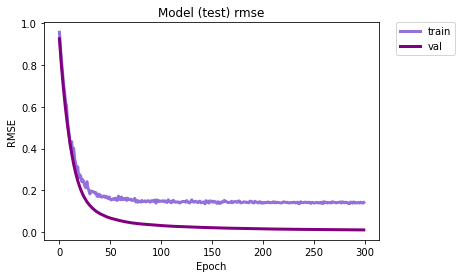

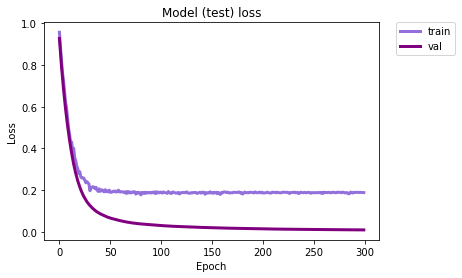

Epoch 1/300
5/5 [==============================] - 1s 118ms/step - loss: 0.1481 - mae: 0.0574 - rmse: 0.1293 - val_loss: 0.0101 - val_mae: 0.0094 - val_rmse: 0.0101
Epoch 2/300
5/5 [==============================] - 0s 94ms/step - loss: 0.1453 - mae: 0.0546 - rmse: 0.1252 - val_loss: 0.0101 - val_mae: 0.0094 - val_rmse: 0.0101
Epoch 3/300
5/5 [==============================] - 0s 81ms/step - loss: 0.1489 - mae: 0.0568 - rmse: 0.1289 - val_loss: 0.0100 - val_mae: 0.0093 - val_rmse: 0.0100
Epoch 4/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1452 - mae: 0.0556 - rmse: 0.1251 - val_loss: 0.0100 - val_mae: 0.0093 - val_rmse: 0.0100
Epoch 5/300
5/5 [==============================] - 1s 111ms/step - loss: 0.1481 - mae: 0.0555 - rmse: 0.1298 - val_loss: 0.0099 - val_mae: 0.0092 - val_rmse: 0.0099
Epoch 6/300
5/5 [==============================] - 0s 89ms/step - loss: 0.1492 - mae: 0.0576 - rmse: 0.1288 - val_loss: 0.0098 - val_mae: 0.0091 - val_rmse: 0.0098
Epoch 7/300
5/

Epoch 51/300
5/5 [==============================] - 0s 76ms/step - loss: 0.1450 - mae: 0.0508 - rmse: 0.1246 - val_loss: 0.0085 - val_mae: 0.0073 - val_rmse: 0.0085
Epoch 52/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1465 - mae: 0.0531 - rmse: 0.1261 - val_loss: 0.0085 - val_mae: 0.0073 - val_rmse: 0.0085
Epoch 53/300
5/5 [==============================] - 0s 84ms/step - loss: 0.1462 - mae: 0.0534 - rmse: 0.1270 - val_loss: 0.0084 - val_mae: 0.0073 - val_rmse: 0.0084
Epoch 54/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1460 - mae: 0.0515 - rmse: 0.1265 - val_loss: 0.0084 - val_mae: 0.0073 - val_rmse: 0.0084
Epoch 55/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1471 - mae: 0.0523 - rmse: 0.1266 - val_loss: 0.0084 - val_mae: 0.0072 - val_rmse: 0.0084
Epoch 56/300
5/5 [==============================] - 0s 81ms/step - loss: 0.1464 - mae: 0.0527 - rmse: 0.1263 - val_loss: 0.0084 - val_mae: 0.0072 - val_rmse: 0.0084
Epoch 57/3

5/5 [==============================] - 0s 92ms/step - loss: 0.1460 - mae: 0.0514 - rmse: 0.1253 - val_loss: 0.0080 - val_mae: 0.0064 - val_rmse: 0.0080
Epoch 101/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1475 - mae: 0.0522 - rmse: 0.1276 - val_loss: 0.0080 - val_mae: 0.0064 - val_rmse: 0.0080
Epoch 102/300
5/5 [==============================] - 0s 91ms/step - loss: 0.1461 - mae: 0.0517 - rmse: 0.1256 - val_loss: 0.0079 - val_mae: 0.0064 - val_rmse: 0.0079
Epoch 103/300
5/5 [==============================] - 0s 87ms/step - loss: 0.1472 - mae: 0.0502 - rmse: 0.1264 - val_loss: 0.0079 - val_mae: 0.0064 - val_rmse: 0.0079
Epoch 104/300
5/5 [==============================] - 0s 87ms/step - loss: 0.1456 - mae: 0.0507 - rmse: 0.1246 - val_loss: 0.0079 - val_mae: 0.0064 - val_rmse: 0.0079
Epoch 105/300
5/5 [==============================] - 0s 88ms/step - loss: 0.1464 - mae: 0.0512 - rmse: 0.1257 - val_loss: 0.0079 - val_mae: 0.0063 - val_rmse: 0.0079
Epoch 106/300
5/5 

5/5 [==============================] - 0s 82ms/step - loss: 0.1455 - mae: 0.0498 - rmse: 0.1245 - val_loss: 0.0078 - val_mae: 0.0060 - val_rmse: 0.0078
Epoch 150/300
5/5 [==============================] - 0s 86ms/step - loss: 0.1447 - mae: 0.0498 - rmse: 0.1238 - val_loss: 0.0078 - val_mae: 0.0060 - val_rmse: 0.0078
Epoch 151/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1458 - mae: 0.0501 - rmse: 0.1251 - val_loss: 0.0078 - val_mae: 0.0060 - val_rmse: 0.0078
Epoch 152/300
5/5 [==============================] - 0s 80ms/step - loss: 0.1445 - mae: 0.0502 - rmse: 0.1252 - val_loss: 0.0078 - val_mae: 0.0060 - val_rmse: 0.0078
Epoch 153/300
5/5 [==============================] - 0s 102ms/step - loss: 0.1454 - mae: 0.0500 - rmse: 0.1245 - val_loss: 0.0078 - val_mae: 0.0060 - val_rmse: 0.0078
Epoch 154/300
5/5 [==============================] - 0s 81ms/step - loss: 0.1459 - mae: 0.0503 - rmse: 0.1253 - val_loss: 0.0078 - val_mae: 0.0060 - val_rmse: 0.0078
Epoch 155/300
5/5

5/5 [==============================] - 0s 89ms/step - loss: 0.1464 - mae: 0.0504 - rmse: 0.1257 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 199/300
5/5 [==============================] - 0s 81ms/step - loss: 0.1458 - mae: 0.0504 - rmse: 0.1252 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 200/300
5/5 [==============================] - 0s 92ms/step - loss: 0.1470 - mae: 0.0500 - rmse: 0.1259 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 201/300
5/5 [==============================] - 0s 84ms/step - loss: 0.1465 - mae: 0.0500 - rmse: 0.1262 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 202/300
5/5 [==============================] - 0s 94ms/step - loss: 0.1454 - mae: 0.0510 - rmse: 0.1261 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 203/300
5/5 [==============================] - 0s 92ms/step - loss: 0.1460 - mae: 0.0496 - rmse: 0.1251 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 204/300
5/5 

5/5 [==============================] - 0s 100ms/step - loss: 0.1458 - mae: 0.0505 - rmse: 0.1256 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 248/300
5/5 [==============================] - 0s 81ms/step - loss: 0.1459 - mae: 0.0494 - rmse: 0.1251 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 249/300
5/5 [==============================] - 0s 97ms/step - loss: 0.1463 - mae: 0.0496 - rmse: 0.1256 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 250/300
5/5 [==============================] - 0s 88ms/step - loss: 0.1464 - mae: 0.0506 - rmse: 0.1257 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 251/300
5/5 [==============================] - 0s 95ms/step - loss: 0.1464 - mae: 0.0500 - rmse: 0.1272 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 252/300
5/5 [==============================] - 0s 100ms/step - loss: 0.1460 - mae: 0.0494 - rmse: 0.1247 - val_loss: 0.0078 - val_mae: 0.0059 - val_rmse: 0.0078
Epoch 253/300
5/

5/5 [==============================] - 0s 95ms/step - loss: 0.1463 - mae: 0.0499 - rmse: 0.1255 - val_loss: 0.0078 - val_mae: 0.0058 - val_rmse: 0.0078
Epoch 297/300
5/5 [==============================] - 0s 82ms/step - loss: 0.1462 - mae: 0.0500 - rmse: 0.1257 - val_loss: 0.0078 - val_mae: 0.0058 - val_rmse: 0.0078
Epoch 298/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1460 - mae: 0.0498 - rmse: 0.1251 - val_loss: 0.0078 - val_mae: 0.0058 - val_rmse: 0.0078
Epoch 299/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1453 - mae: 0.0496 - rmse: 0.1243 - val_loss: 0.0078 - val_mae: 0.0058 - val_rmse: 0.0078
Epoch 300/300
5/5 [==============================] - 0s 95ms/step - loss: 0.1458 - mae: 0.0494 - rmse: 0.1260 - val_loss: 0.0078 - val_mae: 0.0058 - val_rmse: 0.0078
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


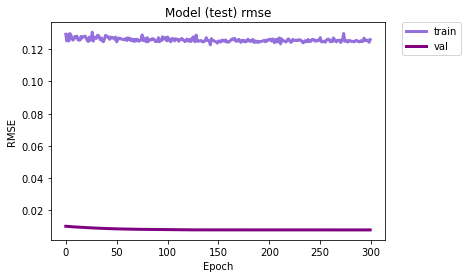

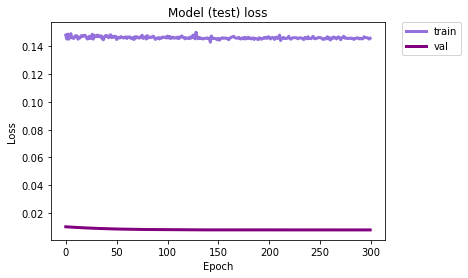

Epoch 1/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1054 - mae: 0.0373 - rmse: 0.1025 - val_loss: 0.2181 - val_mae: 0.0627 - val_rmse: 0.1205
Epoch 2/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1057 - mae: 0.0379 - rmse: 0.1031 - val_loss: 0.2181 - val_mae: 0.0627 - val_rmse: 0.1205
Epoch 3/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1054 - mae: 0.0374 - rmse: 0.1025 - val_loss: 0.2181 - val_mae: 0.0627 - val_rmse: 0.1205
Epoch 4/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1058 - mae: 0.0377 - rmse: 0.1027 - val_loss: 0.2181 - val_mae: 0.0627 - val_rmse: 0.1205
Epoch 5/300
7/7 [==============================] - 1s 76ms/step - loss: 0.1056 - mae: 0.0379 - rmse: 0.1028 - val_loss: 0.2181 - val_mae: 0.0627 - val_rmse: 0.1205
Epoch 6/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1052 - mae: 0.0378 - rmse: 0.1023 - val_loss: 0.2181 - val_mae: 0.0627 - val_rmse: 0.1205
Epoch 7/300
7/7 

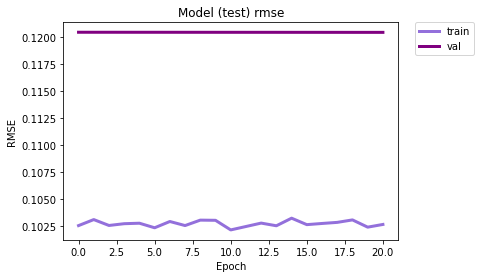

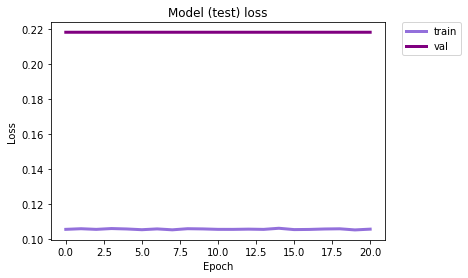

Epoch 1/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1134 - mae: 0.0371 - rmse: 0.1053 - val_loss: 0.0245 - val_mae: 0.0136 - val_rmse: 0.0367
Epoch 2/300
9/9 [==============================] - 1s 88ms/step - loss: 0.1133 - mae: 0.0370 - rmse: 0.1053 - val_loss: 0.0245 - val_mae: 0.0136 - val_rmse: 0.0367
Epoch 3/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1136 - mae: 0.0376 - rmse: 0.1056 - val_loss: 0.0245 - val_mae: 0.0136 - val_rmse: 0.0367
Epoch 4/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1141 - mae: 0.0377 - rmse: 0.1062 - val_loss: 0.0245 - val_mae: 0.0136 - val_rmse: 0.0367
Epoch 5/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1123 - mae: 0.0372 - rmse: 0.1046 - val_loss: 0.0245 - val_mae: 0.0136 - val_rmse: 0.0367
Epoch 6/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1137 - mae: 0.0373 - rmse: 0.1057 - val_loss: 0.0245 - val_mae: 0.0136 - val_rmse: 0.0367
Epoch 7/300
9/9 

Epoch 51/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1135 - mae: 0.0368 - rmse: 0.1055 - val_loss: 0.0245 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 52/300
9/9 [==============================] - 1s 61ms/step - loss: 0.1130 - mae: 0.0373 - rmse: 0.1052 - val_loss: 0.0245 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 53/300
9/9 [==============================] - 1s 61ms/step - loss: 0.1137 - mae: 0.0375 - rmse: 0.1057 - val_loss: 0.0245 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 54/300
9/9 [==============================] - 1s 61ms/step - loss: 0.1130 - mae: 0.0372 - rmse: 0.1051 - val_loss: 0.0245 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 55/300
9/9 [==============================] - 0s 54ms/step - loss: 0.1135 - mae: 0.0372 - rmse: 0.1054 - val_loss: 0.0245 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 56/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1127 - mae: 0.0371 - rmse: 0.1047 - val_loss: 0.0245 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 57/3

9/9 [==============================] - 1s 114ms/step - loss: 0.1134 - mae: 0.0370 - rmse: 0.1058 - val_loss: 0.0244 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 101/300
9/9 [==============================] - 1s 123ms/step - loss: 0.1133 - mae: 0.0372 - rmse: 0.1056 - val_loss: 0.0244 - val_mae: 0.0135 - val_rmse: 0.0366
Epoch 102/300
9/9 [==============================] - 1s 143ms/step - loss: 0.1133 - mae: 0.0374 - rmse: 0.1053 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 103/300
9/9 [==============================] - 1s 128ms/step - loss: 0.1128 - mae: 0.0373 - rmse: 0.1050 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 104/300
9/9 [==============================] - 1s 115ms/step - loss: 0.1135 - mae: 0.0370 - rmse: 0.1059 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 105/300
9/9 [==============================] - 1s 87ms/step - loss: 0.1138 - mae: 0.0369 - rmse: 0.1066 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 106/300

9/9 [==============================] - 1s 92ms/step - loss: 0.1140 - mae: 0.0372 - rmse: 0.1060 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 150/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1134 - mae: 0.0372 - rmse: 0.1053 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 151/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1140 - mae: 0.0374 - rmse: 0.1062 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 152/300
9/9 [==============================] - 1s 97ms/step - loss: 0.1132 - mae: 0.0374 - rmse: 0.1051 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 153/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1136 - mae: 0.0372 - rmse: 0.1057 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 154/300
9/9 [==============================] - 1s 88ms/step - loss: 0.1135 - mae: 0.0369 - rmse: 0.1055 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0366
Epoch 155/300
9/9 

9/9 [==============================] - 1s 86ms/step - loss: 0.1137 - mae: 0.0371 - rmse: 0.1058 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0366
Epoch 199/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1133 - mae: 0.0367 - rmse: 0.1053 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0366
Epoch 200/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1133 - mae: 0.0368 - rmse: 0.1052 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0366
Epoch 201/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1122 - mae: 0.0366 - rmse: 0.1044 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0366
Epoch 202/300
9/9 [==============================] - 1s 94ms/step - loss: 0.1135 - mae: 0.0371 - rmse: 0.1054 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0366
Epoch 203/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1137 - mae: 0.0374 - rmse: 0.1059 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0366
Epoch 204/300
9/9 

9/9 [==============================] - 1s 84ms/step - loss: 0.1139 - mae: 0.0381 - rmse: 0.1061 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0365
Epoch 248/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1132 - mae: 0.0367 - rmse: 0.1051 - val_loss: 0.0243 - val_mae: 0.0133 - val_rmse: 0.0365
Epoch 249/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1138 - mae: 0.0371 - rmse: 0.1061 - val_loss: 0.0243 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 250/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1136 - mae: 0.0371 - rmse: 0.1056 - val_loss: 0.0243 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 251/300
9/9 [==============================] - 1s 94ms/step - loss: 0.1135 - mae: 0.0367 - rmse: 0.1054 - val_loss: 0.0243 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 252/300
9/9 [==============================] - 1s 88ms/step - loss: 0.1132 - mae: 0.0368 - rmse: 0.1051 - val_loss: 0.0243 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 253/300
9/9 

9/9 [==============================] - 1s 87ms/step - loss: 0.1132 - mae: 0.0364 - rmse: 0.1051 - val_loss: 0.0242 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 297/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1125 - mae: 0.0366 - rmse: 0.1045 - val_loss: 0.0242 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 298/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1137 - mae: 0.0372 - rmse: 0.1066 - val_loss: 0.0242 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 299/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1144 - mae: 0.0373 - rmse: 0.1062 - val_loss: 0.0242 - val_mae: 0.0132 - val_rmse: 0.0365
Epoch 300/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1132 - mae: 0.0365 - rmse: 0.1053 - val_loss: 0.0242 - val_mae: 0.0132 - val_rmse: 0.0365
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


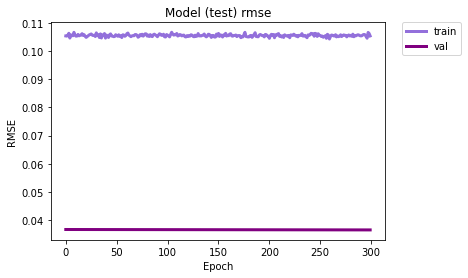

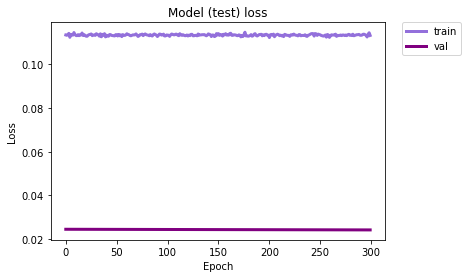

Epoch 1/300
11/11 [==============================] - 1s 87ms/step - loss: 0.0972 - mae: 0.0322 - rmse: 0.0929 - val_loss: 0.1942 - val_mae: 0.0626 - val_rmse: 0.1994
Epoch 2/300
11/11 [==============================] - 1s 80ms/step - loss: 0.0967 - mae: 0.0322 - rmse: 0.0924 - val_loss: 0.1942 - val_mae: 0.0626 - val_rmse: 0.1994
Epoch 3/300
11/11 [==============================] - 1s 82ms/step - loss: 0.0967 - mae: 0.0320 - rmse: 0.0924 - val_loss: 0.1942 - val_mae: 0.0626 - val_rmse: 0.1994
Epoch 4/300
11/11 [==============================] - 1s 87ms/step - loss: 0.0970 - mae: 0.0323 - rmse: 0.0928 - val_loss: 0.1942 - val_mae: 0.0626 - val_rmse: 0.1994
Epoch 5/300
11/11 [==============================] - 1s 88ms/step - loss: 0.0964 - mae: 0.0321 - rmse: 0.0923 - val_loss: 0.1942 - val_mae: 0.0626 - val_rmse: 0.1994
Epoch 6/300
11/11 [==============================] - 1s 88ms/step - loss: 0.0964 - mae: 0.0321 - rmse: 0.0922 - val_loss: 0.1942 - val_mae: 0.0626 - val_rmse: 0.1994
Epoc

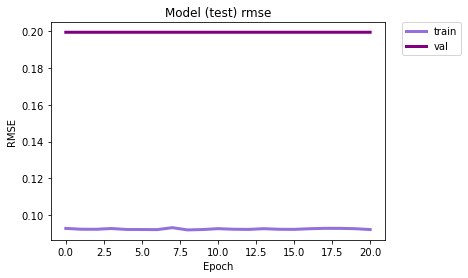

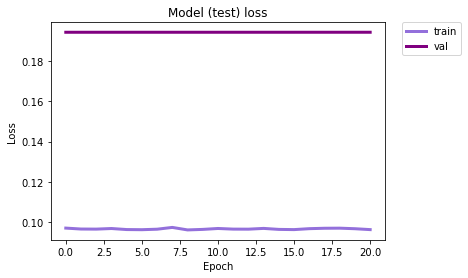

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9964404
Transformed yhat 31.532047
yhat -0.9964605
Transformed yhat 31.531591
yhat -0.9964643
Transformed yhat 31.531506
yhat -0.9964675
Transformed yhat 31.531431
yhat -0.99647033
Transformed yhat 31.531366
yhat -0.9964729
Transformed yhat 31.53131
yhat -0.996476
Transformed yhat 31.531239
yhat -0.99648243
Transformed yhat 31.531092
yhat -0.99650204
Transformed yhat 31.530643
yhat -0.9965022
Transformed yhat 31.530642
yhat -0.9965013
Transformed yhat 31.53066
yhat -0.9965003
Transformed yhat 31.530685
Real data: [34.86177575 31.45098039 31.45098039 31.45098039 31.45098039 31.63311024
 32.56031675 35.9166642  31.74901105 31.45098039 31.45098039 31.45098039
 31.45098039 31.45098039 31.45098039 31.45098039 31.45098039 31.45098039
 31.45098039 31.45098039 31.45098039 31.45098039 31.85695165 31.45098039]
Forecasting values: [31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5, 31.5]


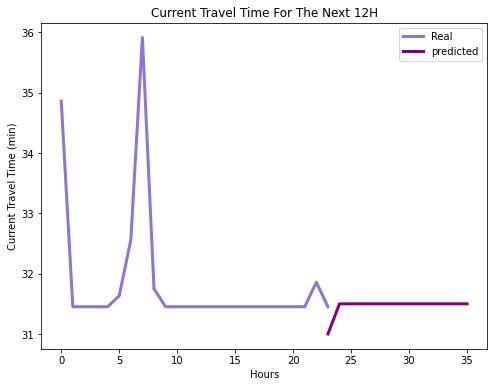

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.3',forecasts[i],hour[i]
        writer.writerow(d)

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 8s 798ms/step - loss: 0.9179 - mae: 0.8972 - rmse: 0.9150 - val_loss: 0.8714 - val_mae: 0.8714 - val_rmse: 0.8714
Epoch 2/300
3/3 [==============================] - 0s 80ms/step - loss: 0.8218 - mae: 0.8016 - rmse: 0.8226 - val_loss: 0.7839 - val_mae: 0.7839 - val_rmse: 0.7839
Epoch 3/300
3/3 [==============================] - 0s 108ms/step - loss: 0.7308 - mae: 0.7075 - rmse: 0.7286 - val_loss: 0.7084 - val_mae: 0.7084 - val_rmse: 0.7084
Epoch 4/300
3/3 [==============================] - 0s 92ms/step - loss: 0.6818 - mae: 0.6638 - rmse: 0.6872 - val_loss: 0.6407 - val_mae: 0.6407 - val_rmse: 0.6407
Epoch 5/300
3/3 [==============================] - 0s 98ms/step - loss: 0.6033 - mae: 0.5866 - rmse: 0.6045 - val_loss: 0.5797 - val_mae: 0.5797 - val_rmse: 0.5797
Epoch 6/300
3/3 [==============================] - 0s 80ms/step - loss: 0.5769 - mae: 0.5592 - rmse: 0.5748 - val_loss: 0.5273 - val_mae: 0.5273 - val_rmse: 0.5273
Epoch 7/300
3/

3/3 [==============================] - 0s 132ms/step - loss: 0.2485 - mae: 0.1380 - rmse: 0.2230 - val_loss: 0.0630 - val_mae: 0.0630 - val_rmse: 0.0630
Epoch 51/300
3/3 [==============================] - 1s 308ms/step - loss: 0.2418 - mae: 0.1317 - rmse: 0.2161 - val_loss: 0.0617 - val_mae: 0.0617 - val_rmse: 0.0617
Epoch 52/300
3/3 [==============================] - 0s 98ms/step - loss: 0.2338 - mae: 0.1277 - rmse: 0.2120 - val_loss: 0.0606 - val_mae: 0.0606 - val_rmse: 0.0606
Epoch 53/300
3/3 [==============================] - 0s 141ms/step - loss: 0.2475 - mae: 0.1346 - rmse: 0.2262 - val_loss: 0.0591 - val_mae: 0.0591 - val_rmse: 0.0591
Epoch 54/300
3/3 [==============================] - 0s 122ms/step - loss: 0.2338 - mae: 0.1266 - rmse: 0.2085 - val_loss: 0.0582 - val_mae: 0.0582 - val_rmse: 0.0582
Epoch 55/300
3/3 [==============================] - 0s 162ms/step - loss: 0.2289 - mae: 0.1217 - rmse: 0.2062 - val_loss: 0.0573 - val_mae: 0.0573 - val_rmse: 0.0573
Epoch 56/300
3/3 [

3/3 [==============================] - 0s 116ms/step - loss: 0.2448 - mae: 0.1058 - rmse: 0.2147 - val_loss: 0.0319 - val_mae: 0.0319 - val_rmse: 0.0319
Epoch 100/300
3/3 [==============================] - 0s 87ms/step - loss: 0.2422 - mae: 0.1084 - rmse: 0.2120 - val_loss: 0.0315 - val_mae: 0.0315 - val_rmse: 0.0315
Epoch 101/300
3/3 [==============================] - 0s 123ms/step - loss: 0.2422 - mae: 0.1000 - rmse: 0.2121 - val_loss: 0.0313 - val_mae: 0.0313 - val_rmse: 0.0313
Epoch 102/300
3/3 [==============================] - 0s 93ms/step - loss: 0.2438 - mae: 0.1098 - rmse: 0.2131 - val_loss: 0.0310 - val_mae: 0.0310 - val_rmse: 0.0310
Epoch 103/300
3/3 [==============================] - 0s 120ms/step - loss: 0.2486 - mae: 0.1103 - rmse: 0.2188 - val_loss: 0.0306 - val_mae: 0.0306 - val_rmse: 0.0306
Epoch 104/300
3/3 [==============================] - 0s 105ms/step - loss: 0.2435 - mae: 0.1025 - rmse: 0.2140 - val_loss: 0.0303 - val_mae: 0.0303 - val_rmse: 0.0303
Epoch 105/300


3/3 [==============================] - 0s 115ms/step - loss: 0.2464 - mae: 0.1012 - rmse: 0.2172 - val_loss: 0.0216 - val_mae: 0.0216 - val_rmse: 0.0216
Epoch 149/300
3/3 [==============================] - 0s 131ms/step - loss: 0.2449 - mae: 0.0978 - rmse: 0.2116 - val_loss: 0.0215 - val_mae: 0.0215 - val_rmse: 0.0215
Epoch 150/300
3/3 [==============================] - 0s 107ms/step - loss: 0.2407 - mae: 0.0967 - rmse: 0.2119 - val_loss: 0.0213 - val_mae: 0.0213 - val_rmse: 0.0213
Epoch 151/300
3/3 [==============================] - 0s 110ms/step - loss: 0.2406 - mae: 0.0971 - rmse: 0.2081 - val_loss: 0.0213 - val_mae: 0.0213 - val_rmse: 0.0213
Epoch 152/300
3/3 [==============================] - 0s 120ms/step - loss: 0.2404 - mae: 0.0918 - rmse: 0.2084 - val_loss: 0.0213 - val_mae: 0.0213 - val_rmse: 0.0213
Epoch 153/300
3/3 [==============================] - 0s 98ms/step - loss: 0.2376 - mae: 0.0934 - rmse: 0.2068 - val_loss: 0.0213 - val_mae: 0.0213 - val_rmse: 0.0213
Epoch 154/300

3/3 [==============================] - 0s 106ms/step - loss: 0.2439 - mae: 0.0932 - rmse: 0.2108 - val_loss: 0.0160 - val_mae: 0.0160 - val_rmse: 0.0160
Epoch 198/300
3/3 [==============================] - 0s 95ms/step - loss: 0.2412 - mae: 0.0902 - rmse: 0.2087 - val_loss: 0.0160 - val_mae: 0.0160 - val_rmse: 0.0160
Epoch 199/300
3/3 [==============================] - 0s 99ms/step - loss: 0.2441 - mae: 0.0905 - rmse: 0.2112 - val_loss: 0.0160 - val_mae: 0.0160 - val_rmse: 0.0160
Epoch 200/300
3/3 [==============================] - 0s 94ms/step - loss: 0.2460 - mae: 0.0936 - rmse: 0.2134 - val_loss: 0.0159 - val_mae: 0.0159 - val_rmse: 0.0159
Epoch 201/300
3/3 [==============================] - 0s 96ms/step - loss: 0.2448 - mae: 0.0927 - rmse: 0.2124 - val_loss: 0.0158 - val_mae: 0.0158 - val_rmse: 0.0158
Epoch 202/300
3/3 [==============================] - 0s 94ms/step - loss: 0.2373 - mae: 0.0930 - rmse: 0.2079 - val_loss: 0.0157 - val_mae: 0.0157 - val_rmse: 0.0157
Epoch 203/300
3/3

3/3 [==============================] - 0s 103ms/step - loss: 0.2479 - mae: 0.0957 - rmse: 0.2148 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 247/300
3/3 [==============================] - 0s 112ms/step - loss: 0.2446 - mae: 0.0910 - rmse: 0.2115 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 248/300
3/3 [==============================] - 0s 116ms/step - loss: 0.2450 - mae: 0.0894 - rmse: 0.2117 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 249/300
3/3 [==============================] - 0s 114ms/step - loss: 0.2463 - mae: 0.0899 - rmse: 0.2129 - val_loss: 0.0128 - val_mae: 0.0128 - val_rmse: 0.0128
Epoch 250/300
3/3 [==============================] - 0s 134ms/step - loss: 0.2460 - mae: 0.0933 - rmse: 0.2123 - val_loss: 0.0128 - val_mae: 0.0128 - val_rmse: 0.0128
Epoch 251/300
3/3 [==============================] - 0s 149ms/step - loss: 0.2458 - mae: 0.0907 - rmse: 0.2135 - val_loss: 0.0127 - val_mae: 0.0127 - val_rmse: 0.0127
Epoch 252/30

3/3 [==============================] - 0s 102ms/step - loss: 0.2430 - mae: 0.0855 - rmse: 0.2097 - val_loss: 0.0110 - val_mae: 0.0110 - val_rmse: 0.0110
Epoch 296/300
3/3 [==============================] - 0s 100ms/step - loss: 0.2478 - mae: 0.0931 - rmse: 0.2148 - val_loss: 0.0109 - val_mae: 0.0109 - val_rmse: 0.0109
Epoch 297/300
3/3 [==============================] - 0s 110ms/step - loss: 0.2470 - mae: 0.0897 - rmse: 0.2137 - val_loss: 0.0109 - val_mae: 0.0109 - val_rmse: 0.0109
Epoch 298/300
3/3 [==============================] - 0s 83ms/step - loss: 0.2455 - mae: 0.0894 - rmse: 0.2132 - val_loss: 0.0108 - val_mae: 0.0108 - val_rmse: 0.0108
Epoch 299/300
3/3 [==============================] - 0s 114ms/step - loss: 0.2456 - mae: 0.0893 - rmse: 0.2125 - val_loss: 0.0108 - val_mae: 0.0108 - val_rmse: 0.0108
Epoch 300/300
3/3 [==============================] - 0s 80ms/step - loss: 0.2454 - mae: 0.0899 - rmse: 0.2119 - val_loss: 0.0108 - val_mae: 0.0108 - val_rmse: 0.0108
dict_keys(['lo

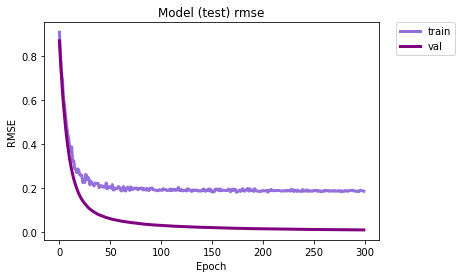

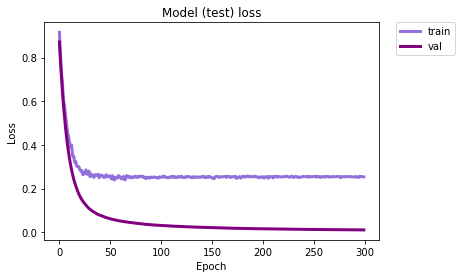

Epoch 1/300
5/5 [==============================] - 0s 100ms/step - loss: 0.2170 - mae: 0.0837 - rmse: 0.1878 - val_loss: 0.0337 - val_mae: 0.0308 - val_rmse: 0.0337
Epoch 2/300
5/5 [==============================] - 0s 81ms/step - loss: 0.2182 - mae: 0.0865 - rmse: 0.1890 - val_loss: 0.0337 - val_mae: 0.0308 - val_rmse: 0.0337
Epoch 3/300
5/5 [==============================] - 0s 94ms/step - loss: 0.2171 - mae: 0.0847 - rmse: 0.1883 - val_loss: 0.0336 - val_mae: 0.0307 - val_rmse: 0.0336
Epoch 4/300
5/5 [==============================] - 0s 85ms/step - loss: 0.2173 - mae: 0.0856 - rmse: 0.1898 - val_loss: 0.0336 - val_mae: 0.0307 - val_rmse: 0.0336
Epoch 5/300
5/5 [==============================] - 0s 78ms/step - loss: 0.2154 - mae: 0.0832 - rmse: 0.1878 - val_loss: 0.0335 - val_mae: 0.0306 - val_rmse: 0.0335
Epoch 6/300
5/5 [==============================] - 0s 87ms/step - loss: 0.2171 - mae: 0.0839 - rmse: 0.1890 - val_loss: 0.0335 - val_mae: 0.0306 - val_rmse: 0.0335
Epoch 7/300
5/5

Epoch 51/300
5/5 [==============================] - 0s 97ms/step - loss: 0.2160 - mae: 0.0837 - rmse: 0.1871 - val_loss: 0.0316 - val_mae: 0.0289 - val_rmse: 0.0316
Epoch 52/300
5/5 [==============================] - 0s 92ms/step - loss: 0.2189 - mae: 0.0861 - rmse: 0.1893 - val_loss: 0.0317 - val_mae: 0.0289 - val_rmse: 0.0317
Epoch 53/300
5/5 [==============================] - 0s 90ms/step - loss: 0.2143 - mae: 0.0855 - rmse: 0.1860 - val_loss: 0.0316 - val_mae: 0.0288 - val_rmse: 0.0316
Epoch 54/300
5/5 [==============================] - 0s 100ms/step - loss: 0.2181 - mae: 0.0864 - rmse: 0.1902 - val_loss: 0.0315 - val_mae: 0.0287 - val_rmse: 0.0315
Epoch 55/300
5/5 [==============================] - 0s 91ms/step - loss: 0.2179 - mae: 0.0841 - rmse: 0.1898 - val_loss: 0.0315 - val_mae: 0.0287 - val_rmse: 0.0315
Epoch 56/300
5/5 [==============================] - 0s 81ms/step - loss: 0.2173 - mae: 0.0840 - rmse: 0.1882 - val_loss: 0.0315 - val_mae: 0.0287 - val_rmse: 0.0315
Epoch 57/

5/5 [==============================] - 0s 95ms/step - loss: 0.2170 - mae: 0.0857 - rmse: 0.1887 - val_loss: 0.0298 - val_mae: 0.0270 - val_rmse: 0.0298
Epoch 101/300
5/5 [==============================] - 0s 109ms/step - loss: 0.2180 - mae: 0.0862 - rmse: 0.1871 - val_loss: 0.0297 - val_mae: 0.0270 - val_rmse: 0.0297
Epoch 102/300
5/5 [==============================] - 0s 97ms/step - loss: 0.2155 - mae: 0.0851 - rmse: 0.1867 - val_loss: 0.0296 - val_mae: 0.0269 - val_rmse: 0.0296
Epoch 103/300
5/5 [==============================] - 0s 91ms/step - loss: 0.2164 - mae: 0.0866 - rmse: 0.1882 - val_loss: 0.0296 - val_mae: 0.0269 - val_rmse: 0.0296
Epoch 104/300
5/5 [==============================] - 0s 95ms/step - loss: 0.2179 - mae: 0.0855 - rmse: 0.1892 - val_loss: 0.0296 - val_mae: 0.0269 - val_rmse: 0.0296
Epoch 105/300
5/5 [==============================] - 0s 101ms/step - loss: 0.2182 - mae: 0.0873 - rmse: 0.1892 - val_loss: 0.0296 - val_mae: 0.0269 - val_rmse: 0.0296
Epoch 106/300
5/

5/5 [==============================] - 1s 131ms/step - loss: 0.2169 - mae: 0.0882 - rmse: 0.1874 - val_loss: 0.0275 - val_mae: 0.0248 - val_rmse: 0.0275
Epoch 150/300
5/5 [==============================] - 1s 130ms/step - loss: 0.2173 - mae: 0.0894 - rmse: 0.1897 - val_loss: 0.0276 - val_mae: 0.0249 - val_rmse: 0.0276
Epoch 151/300
5/5 [==============================] - 0s 107ms/step - loss: 0.2200 - mae: 0.0894 - rmse: 0.1900 - val_loss: 0.0277 - val_mae: 0.0250 - val_rmse: 0.0277
Epoch 152/300
5/5 [==============================] - 1s 144ms/step - loss: 0.2172 - mae: 0.0868 - rmse: 0.1880 - val_loss: 0.0276 - val_mae: 0.0249 - val_rmse: 0.0276
Epoch 153/300
5/5 [==============================] - 1s 124ms/step - loss: 0.2193 - mae: 0.0882 - rmse: 0.1899 - val_loss: 0.0276 - val_mae: 0.0249 - val_rmse: 0.0276
Epoch 154/300
5/5 [==============================] - 1s 123ms/step - loss: 0.2173 - mae: 0.0874 - rmse: 0.1885 - val_loss: 0.0276 - val_mae: 0.0249 - val_rmse: 0.0276
Epoch 155/30

5/5 [==============================] - 0s 97ms/step - loss: 0.2181 - mae: 0.0900 - rmse: 0.1885 - val_loss: 0.0266 - val_mae: 0.0240 - val_rmse: 0.0266
Epoch 199/300
5/5 [==============================] - 0s 90ms/step - loss: 0.2163 - mae: 0.0892 - rmse: 0.1869 - val_loss: 0.0265 - val_mae: 0.0240 - val_rmse: 0.0265
Epoch 200/300
5/5 [==============================] - 0s 88ms/step - loss: 0.2214 - mae: 0.0919 - rmse: 0.1914 - val_loss: 0.0265 - val_mae: 0.0239 - val_rmse: 0.0265
Epoch 201/300
5/5 [==============================] - 0s 91ms/step - loss: 0.2161 - mae: 0.0881 - rmse: 0.1865 - val_loss: 0.0265 - val_mae: 0.0239 - val_rmse: 0.0265
Epoch 202/300
5/5 [==============================] - 0s 77ms/step - loss: 0.2180 - mae: 0.0876 - rmse: 0.1881 - val_loss: 0.0265 - val_mae: 0.0239 - val_rmse: 0.0265
Epoch 203/300
5/5 [==============================] - 0s 94ms/step - loss: 0.2148 - mae: 0.0873 - rmse: 0.1863 - val_loss: 0.0264 - val_mae: 0.0238 - val_rmse: 0.0264
Epoch 204/300
5/5 

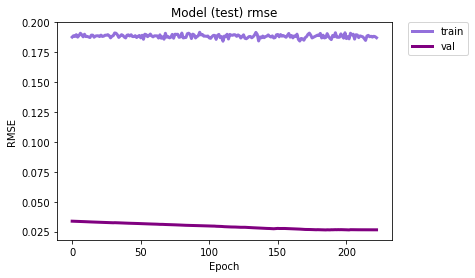

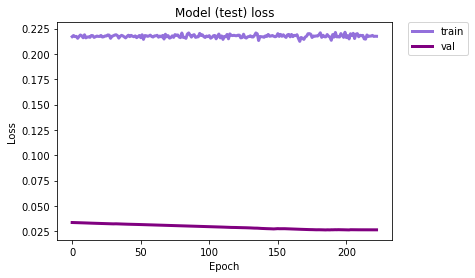

Epoch 1/300
7/7 [==============================] - 1s 105ms/step - loss: 0.1641 - mae: 0.0718 - rmse: 0.1621 - val_loss: 0.3094 - val_mae: 0.1023 - val_rmse: 0.1748
Epoch 2/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1614 - mae: 0.0709 - rmse: 0.1594 - val_loss: 0.3094 - val_mae: 0.1023 - val_rmse: 0.1747
Epoch 3/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1604 - mae: 0.0693 - rmse: 0.1574 - val_loss: 0.3093 - val_mae: 0.1023 - val_rmse: 0.1747
Epoch 4/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1608 - mae: 0.0704 - rmse: 0.1583 - val_loss: 0.3093 - val_mae: 0.1023 - val_rmse: 0.1747
Epoch 5/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1619 - mae: 0.0702 - rmse: 0.1597 - val_loss: 0.3093 - val_mae: 0.1022 - val_rmse: 0.1747
Epoch 6/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1635 - mae: 0.0701 - rmse: 0.1613 - val_loss: 0.3093 - val_mae: 0.1022 - val_rmse: 0.1747
Epoch 7/300
7/7

Epoch 51/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1629 - mae: 0.0706 - rmse: 0.1606 - val_loss: 0.3090 - val_mae: 0.1014 - val_rmse: 0.1740
Epoch 52/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1643 - mae: 0.0714 - rmse: 0.1613 - val_loss: 0.3090 - val_mae: 0.1014 - val_rmse: 0.1740
Epoch 53/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1630 - mae: 0.0703 - rmse: 0.1611 - val_loss: 0.3090 - val_mae: 0.1014 - val_rmse: 0.1740
Epoch 54/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1626 - mae: 0.0689 - rmse: 0.1605 - val_loss: 0.3090 - val_mae: 0.1014 - val_rmse: 0.1740
Epoch 55/300
7/7 [==============================] - 1s 76ms/step - loss: 0.1632 - mae: 0.0709 - rmse: 0.1614 - val_loss: 0.3090 - val_mae: 0.1014 - val_rmse: 0.1740
Epoch 56/300
7/7 [==============================] - 1s 75ms/step - loss: 0.1612 - mae: 0.0709 - rmse: 0.1582 - val_loss: 0.3090 - val_mae: 0.1014 - val_rmse: 0.1740
Epoch 57/3

7/7 [==============================] - 1s 163ms/step - loss: 0.1593 - mae: 0.0690 - rmse: 0.1577 - val_loss: 0.3087 - val_mae: 0.1006 - val_rmse: 0.1734
Epoch 101/300
7/7 [==============================] - 1s 143ms/step - loss: 0.1607 - mae: 0.0709 - rmse: 0.1567 - val_loss: 0.3087 - val_mae: 0.1006 - val_rmse: 0.1734
Epoch 102/300
7/7 [==============================] - 1s 158ms/step - loss: 0.1605 - mae: 0.0710 - rmse: 0.1577 - val_loss: 0.3086 - val_mae: 0.1005 - val_rmse: 0.1733
Epoch 103/300
7/7 [==============================] - 1s 165ms/step - loss: 0.1621 - mae: 0.0692 - rmse: 0.1598 - val_loss: 0.3086 - val_mae: 0.1005 - val_rmse: 0.1733
Epoch 104/300
7/7 [==============================] - 1s 122ms/step - loss: 0.1605 - mae: 0.0687 - rmse: 0.1586 - val_loss: 0.3086 - val_mae: 0.1005 - val_rmse: 0.1733
Epoch 105/300
7/7 [==============================] - 1s 131ms/step - loss: 0.1629 - mae: 0.0711 - rmse: 0.1610 - val_loss: 0.3086 - val_mae: 0.1005 - val_rmse: 0.1733
Epoch 106/30

7/7 [==============================] - 1s 91ms/step - loss: 0.1587 - mae: 0.0710 - rmse: 0.1571 - val_loss: 0.3083 - val_mae: 0.0997 - val_rmse: 0.1727
Epoch 150/300
7/7 [==============================] - 1s 96ms/step - loss: 0.1599 - mae: 0.0686 - rmse: 0.1578 - val_loss: 0.3083 - val_mae: 0.0997 - val_rmse: 0.1727
Epoch 151/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1620 - mae: 0.0719 - rmse: 0.1596 - val_loss: 0.3083 - val_mae: 0.0997 - val_rmse: 0.1727
Epoch 152/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1628 - mae: 0.0730 - rmse: 0.1611 - val_loss: 0.3083 - val_mae: 0.0997 - val_rmse: 0.1727
Epoch 153/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1619 - mae: 0.0718 - rmse: 0.1590 - val_loss: 0.3083 - val_mae: 0.0997 - val_rmse: 0.1727
Epoch 154/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1599 - mae: 0.0707 - rmse: 0.1582 - val_loss: 0.3083 - val_mae: 0.0997 - val_rmse: 0.1727
Epoch 155/300
7/7 

7/7 [==============================] - 1s 110ms/step - loss: 0.1624 - mae: 0.0704 - rmse: 0.1604 - val_loss: 0.3080 - val_mae: 0.0990 - val_rmse: 0.1721
Epoch 199/300
7/7 [==============================] - 1s 108ms/step - loss: 0.1629 - mae: 0.0728 - rmse: 0.1609 - val_loss: 0.3080 - val_mae: 0.0990 - val_rmse: 0.1721
Epoch 200/300
7/7 [==============================] - 1s 96ms/step - loss: 0.1652 - mae: 0.0720 - rmse: 0.1629 - val_loss: 0.3080 - val_mae: 0.0990 - val_rmse: 0.1721
Epoch 201/300
7/7 [==============================] - 1s 97ms/step - loss: 0.1625 - mae: 0.0717 - rmse: 0.1605 - val_loss: 0.3080 - val_mae: 0.0990 - val_rmse: 0.1721
Epoch 202/300
7/7 [==============================] - 1s 101ms/step - loss: 0.1635 - mae: 0.0723 - rmse: 0.1610 - val_loss: 0.3080 - val_mae: 0.0989 - val_rmse: 0.1721
Epoch 203/300
7/7 [==============================] - 1s 100ms/step - loss: 0.1594 - mae: 0.0687 - rmse: 0.1566 - val_loss: 0.3080 - val_mae: 0.0989 - val_rmse: 0.1721
Epoch 204/300


7/7 [==============================] - 1s 86ms/step - loss: 0.1613 - mae: 0.0702 - rmse: 0.1589 - val_loss: 0.3077 - val_mae: 0.0982 - val_rmse: 0.1715
Epoch 248/300
7/7 [==============================] - 1s 78ms/step - loss: 0.1622 - mae: 0.0701 - rmse: 0.1593 - val_loss: 0.3077 - val_mae: 0.0982 - val_rmse: 0.1715
Epoch 249/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1612 - mae: 0.0704 - rmse: 0.1596 - val_loss: 0.3077 - val_mae: 0.0982 - val_rmse: 0.1715
Epoch 250/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1644 - mae: 0.0742 - rmse: 0.1625 - val_loss: 0.3077 - val_mae: 0.0982 - val_rmse: 0.1715
Epoch 251/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1618 - mae: 0.0711 - rmse: 0.1579 - val_loss: 0.3077 - val_mae: 0.0981 - val_rmse: 0.1715
Epoch 252/300
7/7 [==============================] - 1s 83ms/step - loss: 0.1610 - mae: 0.0704 - rmse: 0.1581 - val_loss: 0.3077 - val_mae: 0.0981 - val_rmse: 0.1715
Epoch 253/300
7/7 

7/7 [==============================] - 1s 88ms/step - loss: 0.1624 - mae: 0.0705 - rmse: 0.1600 - val_loss: 0.3075 - val_mae: 0.0976 - val_rmse: 0.1710
Epoch 297/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1622 - mae: 0.0725 - rmse: 0.1604 - val_loss: 0.3075 - val_mae: 0.0976 - val_rmse: 0.1710
Epoch 298/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1630 - mae: 0.0731 - rmse: 0.1608 - val_loss: 0.3075 - val_mae: 0.0976 - val_rmse: 0.1710
Epoch 299/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1621 - mae: 0.0701 - rmse: 0.1595 - val_loss: 0.3075 - val_mae: 0.0976 - val_rmse: 0.1710
Epoch 300/300
7/7 [==============================] - 1s 80ms/step - loss: 0.1603 - mae: 0.0698 - rmse: 0.1574 - val_loss: 0.3075 - val_mae: 0.0975 - val_rmse: 0.1710
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


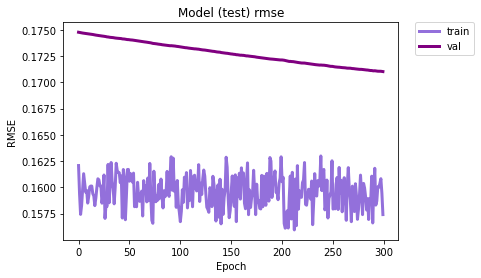

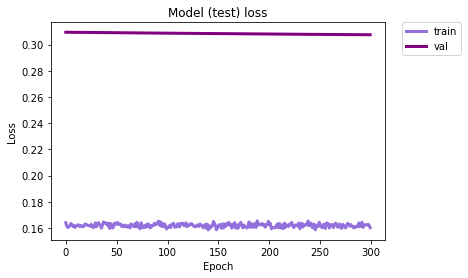

Epoch 1/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1706 - mae: 0.0727 - rmse: 0.1599 - val_loss: 0.0459 - val_mae: 0.0348 - val_rmse: 0.0609
Epoch 2/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1712 - mae: 0.0695 - rmse: 0.1599 - val_loss: 0.0459 - val_mae: 0.0348 - val_rmse: 0.0609
Epoch 3/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1731 - mae: 0.0722 - rmse: 0.1613 - val_loss: 0.0459 - val_mae: 0.0348 - val_rmse: 0.0609
Epoch 4/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1708 - mae: 0.0694 - rmse: 0.1598 - val_loss: 0.0459 - val_mae: 0.0348 - val_rmse: 0.0609
Epoch 5/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1682 - mae: 0.0680 - rmse: 0.1573 - val_loss: 0.0459 - val_mae: 0.0348 - val_rmse: 0.0609
Epoch 6/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1699 - mae: 0.0685 - rmse: 0.1589 - val_loss: 0.0459 - val_mae: 0.0348 - val_rmse: 0.0609
Epoch 7/300
9/9 

9/9 [==============================] - 1s 80ms/step - loss: 0.1683 - mae: 0.0676 - rmse: 0.1566 - val_loss: 0.0457 - val_mae: 0.0347 - val_rmse: 0.0607
Epoch 51/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1708 - mae: 0.0695 - rmse: 0.1595 - val_loss: 0.0457 - val_mae: 0.0347 - val_rmse: 0.0607
Epoch 52/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1706 - mae: 0.0700 - rmse: 0.1597 - val_loss: 0.0457 - val_mae: 0.0347 - val_rmse: 0.0607
Epoch 53/300
9/9 [==============================] - 1s 93ms/step - loss: 0.1694 - mae: 0.0705 - rmse: 0.1584 - val_loss: 0.0457 - val_mae: 0.0347 - val_rmse: 0.0607
Epoch 54/300
9/9 [==============================] - 1s 88ms/step - loss: 0.1717 - mae: 0.0716 - rmse: 0.1599 - val_loss: 0.0457 - val_mae: 0.0347 - val_rmse: 0.0607
Epoch 55/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1695 - mae: 0.0691 - rmse: 0.1584 - val_loss: 0.0457 - val_mae: 0.0346 - val_rmse: 0.0607
Epoch 56/300
9/9 [=====

Epoch 100/300
9/9 [==============================] - 0s 45ms/step - loss: 0.1712 - mae: 0.0685 - rmse: 0.1600 - val_loss: 0.0456 - val_mae: 0.0345 - val_rmse: 0.0605
Epoch 101/300
9/9 [==============================] - 0s 45ms/step - loss: 0.1680 - mae: 0.0669 - rmse: 0.1568 - val_loss: 0.0456 - val_mae: 0.0345 - val_rmse: 0.0605
Epoch 102/300
9/9 [==============================] - 0s 45ms/step - loss: 0.1684 - mae: 0.0695 - rmse: 0.1577 - val_loss: 0.0455 - val_mae: 0.0345 - val_rmse: 0.0605
Epoch 103/300
9/9 [==============================] - 0s 44ms/step - loss: 0.1703 - mae: 0.0689 - rmse: 0.1596 - val_loss: 0.0456 - val_mae: 0.0345 - val_rmse: 0.0605
Epoch 104/300
9/9 [==============================] - 0s 43ms/step - loss: 0.1702 - mae: 0.0696 - rmse: 0.1588 - val_loss: 0.0455 - val_mae: 0.0345 - val_rmse: 0.0605
Epoch 105/300
9/9 [==============================] - 1s 59ms/step - loss: 0.1698 - mae: 0.0690 - rmse: 0.1586 - val_loss: 0.0455 - val_mae: 0.0345 - val_rmse: 0.0605
Epoc

9/9 [==============================] - 1s 65ms/step - loss: 0.1683 - mae: 0.0684 - rmse: 0.1574 - val_loss: 0.0455 - val_mae: 0.0344 - val_rmse: 0.0603
Epoch 150/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1702 - mae: 0.0710 - rmse: 0.1587 - val_loss: 0.0455 - val_mae: 0.0344 - val_rmse: 0.0603
Epoch 151/300
9/9 [==============================] - 1s 129ms/step - loss: 0.1708 - mae: 0.0708 - rmse: 0.1604 - val_loss: 0.0455 - val_mae: 0.0344 - val_rmse: 0.0603
Epoch 152/300
9/9 [==============================] - 1s 58ms/step - loss: 0.1700 - mae: 0.0685 - rmse: 0.1585 - val_loss: 0.0455 - val_mae: 0.0344 - val_rmse: 0.0603
Epoch 153/300
9/9 [==============================] - 0s 55ms/step - loss: 0.1704 - mae: 0.0681 - rmse: 0.1590 - val_loss: 0.0455 - val_mae: 0.0344 - val_rmse: 0.0603
Epoch 154/300
9/9 [==============================] - 0s 53ms/step - loss: 0.1713 - mae: 0.0701 - rmse: 0.1597 - val_loss: 0.0454 - val_mae: 0.0344 - val_rmse: 0.0603
Epoch 155/300
9/9

9/9 [==============================] - 1s 62ms/step - loss: 0.1712 - mae: 0.0695 - rmse: 0.1595 - val_loss: 0.0454 - val_mae: 0.0343 - val_rmse: 0.0602
Epoch 199/300
9/9 [==============================] - 1s 59ms/step - loss: 0.1666 - mae: 0.0690 - rmse: 0.1554 - val_loss: 0.0454 - val_mae: 0.0343 - val_rmse: 0.0602
Epoch 200/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1697 - mae: 0.0695 - rmse: 0.1582 - val_loss: 0.0454 - val_mae: 0.0343 - val_rmse: 0.0602
Epoch 201/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1691 - mae: 0.0693 - rmse: 0.1581 - val_loss: 0.0454 - val_mae: 0.0343 - val_rmse: 0.0602
Epoch 202/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1705 - mae: 0.0698 - rmse: 0.1591 - val_loss: 0.0454 - val_mae: 0.0343 - val_rmse: 0.0602
Epoch 203/300
9/9 [==============================] - 0s 56ms/step - loss: 0.1698 - mae: 0.0681 - rmse: 0.1584 - val_loss: 0.0454 - val_mae: 0.0343 - val_rmse: 0.0602
Epoch 204/300
9/9 

9/9 [==============================] - 1s 63ms/step - loss: 0.1709 - mae: 0.0716 - rmse: 0.1600 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 248/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1707 - mae: 0.0707 - rmse: 0.1594 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 249/300
9/9 [==============================] - 1s 59ms/step - loss: 0.1714 - mae: 0.0696 - rmse: 0.1603 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 250/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1700 - mae: 0.0697 - rmse: 0.1589 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 251/300
9/9 [==============================] - 1s 60ms/step - loss: 0.1713 - mae: 0.0688 - rmse: 0.1605 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 252/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1716 - mae: 0.0715 - rmse: 0.1612 - val_loss: 0.0454 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 253/300
9/9 

9/9 [==============================] - 1s 65ms/step - loss: 0.1704 - mae: 0.0697 - rmse: 0.1593 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 297/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1704 - mae: 0.0715 - rmse: 0.1591 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 298/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1702 - mae: 0.0713 - rmse: 0.1590 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 299/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1691 - mae: 0.0694 - rmse: 0.1580 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
Epoch 300/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1706 - mae: 0.0696 - rmse: 0.1596 - val_loss: 0.0453 - val_mae: 0.0342 - val_rmse: 0.0601
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


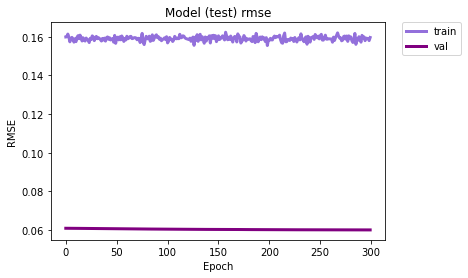

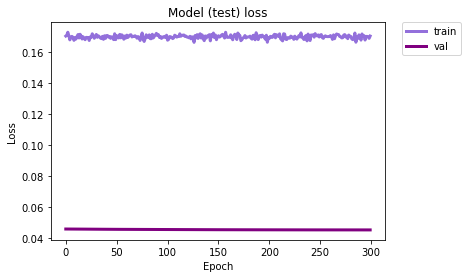

Epoch 1/300
11/11 [==============================] - 1s 63ms/step - loss: 0.1485 - mae: 0.0653 - rmse: 0.1431 - val_loss: 0.2200 - val_mae: 0.0849 - val_rmse: 0.2229
Epoch 2/300
11/11 [==============================] - 1s 63ms/step - loss: 0.1478 - mae: 0.0645 - rmse: 0.1425 - val_loss: 0.2200 - val_mae: 0.0849 - val_rmse: 0.2229
Epoch 3/300
11/11 [==============================] - 1s 54ms/step - loss: 0.1462 - mae: 0.0631 - rmse: 0.1408 - val_loss: 0.2200 - val_mae: 0.0849 - val_rmse: 0.2229
Epoch 4/300
11/11 [==============================] - 1s 61ms/step - loss: 0.1445 - mae: 0.0623 - rmse: 0.1391 - val_loss: 0.2200 - val_mae: 0.0849 - val_rmse: 0.2229
Epoch 5/300
11/11 [==============================] - 1s 62ms/step - loss: 0.1458 - mae: 0.0629 - rmse: 0.1402 - val_loss: 0.2200 - val_mae: 0.0849 - val_rmse: 0.2228
Epoch 6/300
11/11 [==============================] - 1s 61ms/step - loss: 0.1467 - mae: 0.0631 - rmse: 0.1413 - val_loss: 0.2200 - val_mae: 0.0849 - val_rmse: 0.2229
Epoc

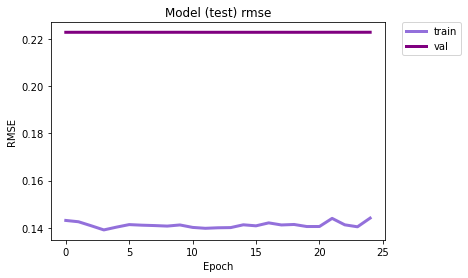

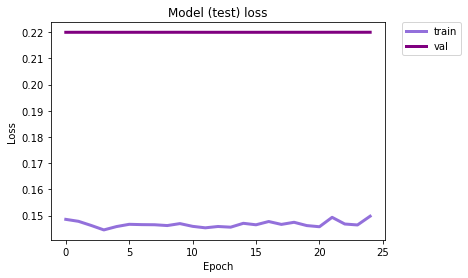

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.9690339
Transformed yhat 76.29476
yhat 0.9692228
Transformed yhat 76.299065
yhat 0.96930915
Transformed yhat 76.301025
yhat 0.96940535
Transformed yhat 76.30322
yhat 0.9695061
Transformed yhat 76.30551
yhat 0.96960104
Transformed yhat 76.30768
yhat 0.96968716
Transformed yhat 76.30964
yhat 0.96981364
Transformed yhat 76.312515
yhat 0.97005635
Transformed yhat 76.31805
yhat 0.97012347
Transformed yhat 76.31958
yhat 0.9701777
Transformed yhat 76.32081
yhat 0.9702283
Transformed yhat 76.32197
Real data: [71.05882353 76.         76.         76.         76.28846154 76.62745098
 74.52941176 68.26923077 75.58823529 76.         76.         76.
 76.         76.         76.         76.         76.         76.
 76.         76.         76.         76.         75.21153846 76.        ]
Forecasting values: [76.3, 76.3, 76.3, 76.3, 76.3, 76.3, 76.3, 76.3, 76.3, 76.3, 76.3, 76.3]


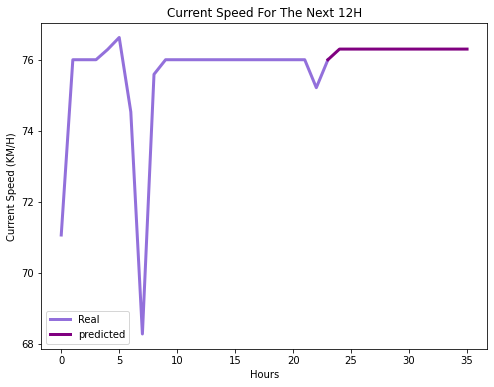

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.3',forecastSpeed[i],hour[i]
        writer.writerow(d)